<a href="https://colab.research.google.com/github/insaiyancvk/speedyblackman/blob/main/speedy_work_turns.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Starting with Left/Right work

In [1]:
from google.colab import drive
drive._mount('/content/drive')
# from IPython.display import Image
!pip install -q python-telegram-bot

Mounted at /content/drive
     |████████████████████████████████| 495 kB 5.3 MB/s 
     |████████████████████████████████| 58 kB 5.7 MB/s 
     |████████████████████████████████| 428 kB 42.1 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires tornado~=5.1.0; python_version >= "3.0", but you have tornado 6.1 which is incompatible.


TRY MOBILENETV2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os, telegram, json, cv2, time, random, zipfile, shutil
from math import floor
from PIL import Image

import torch
import torchvision

from torch.utils.data import DataLoader
from torch.cuda.amp import autocast
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# from torchvision.models.resnet import resnet50
import torchvision.transforms as transforms
import torchvision.datasets as datasets

from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings("ignore")

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"{device} activated.")

cuda activated.


In [ ]:
!pip install --upgrade --force-reinstall --no-deps kaggle

In [12]:
!kaggle datasets download -d insaiyancvk/directions-nfsr

100% 10.3G/10.3G [03:37<00:00, 40.3MB/s]
100% 10.3G/10.3G [03:37<00:00, 50.7MB/s]


In [13]:
# print("Initializing kaggle")
# !rm -rf /root/.kaggle && mkdir /root/.kaggle && cp /content/drive/MyDrive/kaggle.json . && mv kaggle.json /root/.kaggle/kaggle.json

# print("Downloading the dataset")
# !kaggle datasets download -d insaiyancvk/directions-nfsr

print("Extracting the dataset")
with zipfile.ZipFile("directions-nfsr.zip") as zf:
  for member in tqdm(zf.infolist(), desc='Extracting'):
    try:
      zf.extract(member, "/content")
    except zipfile.error:
      pass
!rm directions-nfsr.zip

Extracting the dataset


Extracting:   0%|          | 0/52185 [00:00<?, ?it/s]

In [14]:
#@title Telegram bot
class send(): 

  def __init__(self):
    f = open ('/content/drive/MyDrive/tel.json', 'r')
    self.tel = json.load(f)
    f.close()
    self.bot = telegram.Bot(token=self.tel['token']) 

  def msg(self, mesg):
    self.bot.sendMessage(chat_id=self.tel['nnboiid'], text=mesg)

  def pic(self, path):
    self.bot.sendPhoto(chat_id=self.tel['nnboiid'], photo=open(path, 'rb'))
bot = send()

In [15]:
print("Initializing classes")

class_list = [
              'a',
              'center',
              'd']

print("Creating workspace")

drive = os.path.join("drive","MyDrive")
FOLDERS = {
    "TRAIN": os.path.join("train"),
    "TEST": os.path.join("test"),
    "WORKSPACE": os.path.join(drive,"speedata","workspace"),
    "MODELS": os.path.join(drive,"speedata","workspace","models"),
    "PERFORMANCE": os.path.join(drive,"speedata","workspace","performance")
}

for key in FOLDERS:
  if not os.path.isdir(FOLDERS[key]):
    print(key, "directory doesn't exist. Creating one.")
    os.mkdir(FOLDERS[key])
    print(key, "directory created.")

Initializing classes
Creating workspace


In [ ]:
# SPLIT_FOLDERS = {
#     'TRAIN': os.path.join("set1","train"),
#     'TRAIN_w': os.path.join("set1","train","w"),
#     'TRAIN_s': os.path.join("set1","train","s"),
#     'TEST': os.path.join("set1","test"),
#     'TEST_w': os.path.join("set1","test","w"),
#     'TEST_s': os.path.join("set1","test","s")
# }
# move_a = os.listdir(SPLIT_FOLDERS['TRAIN_w'])[:floor((len(os.listdir(SPLIT_FOLDERS['TRAIN_a'])))*0.375)]
# move_d = os.listdir(SPLIT_FOLDERS['TRAIN_s'])[:floor((len(os.listdir(SPLIT_FOLDERS['TRAIN_d'])))*0.375)]

# print("Moving 37.5% of train data of set 'a' to test set")
# for path in move_a:
#   shutil.move(SPLIT_FOLDERS['TRAIN_a']+"/"+path, SPLIT_FOLDERS['TEST_a'])
# print("Moving 37.5% of train data of set 'd' to test set")
# for path in move_d:
#   shutil.move(SPLIT_FOLDERS['TRAIN_d']+"/"+path, SPLIT_FOLDERS['TEST_d'])

### Defining the transformations on train and test data

In [16]:
print("Defining the transformations for the speedy data")
transformations = {
    "TRAIN": transforms.Compose([
                        transforms.Resize([256,256]),
                        transforms.ColorJitter(brightness=(0.8,1.5), contrast=(0.8,1.5), saturation=(0.8,1.5)),
                        # transforms.RandomInvert(0.5),
                        # transforms.RandomRotation(degrees=(-10,10)),
                        transforms.ToTensor(),
                        transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
    ]),
    "TEST": transforms.Compose([
                      transforms.Resize([256,256]),
                      transforms.ToTensor(),
                      transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
    ])
}

Defining the transformations for the speedy data


### Define dataset of the _speedata_

In [17]:

print("Creating a dataset of the speedata")
dataset = {
    "TRAIN": datasets.ImageFolder(
        FOLDERS["TRAIN"],
        transform = transformations["TRAIN"]
    ),
    "TEST": datasets.ImageFolder(
        FOLDERS["TEST"],
        transform = transformations["TEST"]
    )
}

Creating a dataset of the speedata


### Create Dataloader of the _speedata_

In [18]:
BATCH =  32#@param {type:"integer"}

In [19]:
print("Creating dataloaders")
dataloader = {
    "TRAIN": DataLoader(
        dataset["TRAIN"],
        batch_size = BATCH,
        shuffle = True
    ),
    "TEST": DataLoader(
        dataset["TEST"],
        batch_size = BATCH,
        shuffle = True
    )
}
print("Data preprocessing completed.")

Creating dataloaders
Data preprocessing completed.


# The G

In [20]:
#@title Epoch function

def epoch(model, test_loader ,train_loader, loss_func, optim, device):

  test_loss = 0
  test_accuracy = 0
  train_loss = 0
  train_accuracy = 0

  model = model.to(device)

  print("\t\tTraining the Neural Network")
  model.train(True)
  for image, label in tqdm(train_loader):
      optim.zero_grad()      
      with autocast():
        output = model.forward(image.to(device).half())
      # output = model(image.to(device))
      loss = loss_func(
        output,
        label.to(device)
        )
      loss.backward()
      optim.step()

      accuracy = np.average(
            np.argmax(
              output.cpu().detach().numpy(), axis=1) == label.cpu().detach().numpy()
        )

      train_loss += loss.item()/len(train_loader) # training average loss
      train_accuracy += accuracy/len(train_loader) # training average accuracy
  model.train(False)

  print("\t\tValidating Neural Network")
  model.eval()

  for image, label in tqdm(test_loader):
      with autocast():
        output = model.forward(image.to(device).half())
      # output = model(image.to(device))
      loss = loss_func(
        output,
        label.to(device)
      )
      
      accuracy = np.average(
        np.argmax(
            output.cpu().detach().numpy(), axis=1) == label.cpu().detach().numpy()
        )

      test_loss += loss.item()/len(test_loader) # Validation average loss
      test_accuracy += accuracy/len(test_loader) # Validation average accuracy
      
  return (

    # TRAIN LOSS
    train_loss,

    # TRAIN ACCURACY
    train_accuracy,

    # TEST LOSS, ACCURACY
    test_loss,
    test_accuracy
  )

In [21]:
EPOCH =  15#@param {type:"integer"}

In [ ]:
!pip install -q pretrainedmodels
import pretrainedmodels

[Reference](https://medium.com/analytics-vidhya/how-to-add-additional-layers-in-a-pre-trained-model-using-pytorch-5627002c75a5)

In [ ]:
#@title Resnet18 extra layers

class Resnet18(nn.Module):
  def __init__(self):
      super(Resnet18, self).__init__()
      self.model =  pretrainedmodels.__dict__['resnet18'](pretrained='imagenet')
      
      self.classifier_layer = nn.Sequential(
          nn.Linear(512 , 256),
          nn.BatchNorm1d(256),
          nn.Dropout(0.2),
          nn.Linear(256 , 128),
          nn.Linear(128 , 2)
      )

  def forward(self, x):
    batch_size ,_,_,_ = x.shape     #taking out batch_size from input image
    x = self.model.features(x)
    x = torch.nn.functional.adaptive_avg_pool2d(x,1).reshape(batch_size,-1)     # then reshaping the batch_size
    x = self.classifier_layer(x)
    return x
# model = Resnet18()
# model.fc = nn.Linear(model.fc.in_features,2)
# model.fc.register_forward_hook(lambda m, inp, out: F.dropout(out, p=0.5, training=m.training)) # add a dropout layer

In [ ]:
#@title install efficientnet
!pip install efficientnet_pytorch

In [ ]:
#@title import efficientnet
from efficientnet_pytorch import EfficientNet
model = EfficientNet.from_pretrained('efficientnet-b0', num_classes=2)

In [ ]:
#@title AlexNet [reference](https://github.com/dansuh17/alexnet-pytorch/blob/master/model.py)
class AlexNet(nn.Module):
    """
    Neural network model consisting of layers propsed by AlexNet paper.
    """
    def __init__(self, num_classes=2):
        """
        Define and allocate layers for this neural net.
        Args:
            num_classes (int): number of classes to predict with this model
        """
        super().__init__()
        # input size should be : (b x 3 x 227 x 227)
        # The image in the original paper states that width and height are 224 pixels, but
        # the dimensions after first convolution layer do not lead to 55 x 55.
        self.net = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=96, kernel_size=11, stride=4),  # (b x 96 x 55 x 55)
            nn.ReLU(),
            nn.LocalResponseNorm(size=5, alpha=0.0001, beta=0.75, k=2),  # section 3.3
            nn.MaxPool2d(kernel_size=3, stride=2),  # (b x 96 x 27 x 27)
            nn.Conv2d(96, 256, 5, padding=2),  # (b x 256 x 27 x 27)
            nn.ReLU(),
            nn.LocalResponseNorm(size=5, alpha=0.0001, beta=0.75, k=2),
            nn.MaxPool2d(kernel_size=3, stride=2),  # (b x 256 x 13 x 13)
            nn.Conv2d(256, 384, 3, padding=1),  # (b x 384 x 13 x 13)
            nn.ReLU(),
            nn.Conv2d(384, 384, 3, padding=1),  # (b x 384 x 13 x 13)
            nn.ReLU(),
            nn.Conv2d(384, 256, 3, padding=1),  # (b x 256 x 13 x 13)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),  # (b x 256 x 6 x 6)
        )
        # classifier is just a name for linear layers
        self.classifier = nn.Sequential(
            nn.Dropout(p=0.5, inplace=True),
            nn.Linear(in_features=(256 * 6 * 6), out_features=4096),
            nn.ReLU(),
            nn.Dropout(p=0.5, inplace=True),
            nn.Linear(in_features=4096, out_features=4096),
            nn.ReLU(),
            nn.Linear(in_features=4096, out_features=num_classes),
        )
        self.init_bias()  # initialize bias

    def init_bias(self):
        for layer in self.net:
            if isinstance(layer, nn.Conv2d):
                nn.init.normal_(layer.weight, mean=0, std=0.01)
                nn.init.constant_(layer.bias, 0)
        # original paper = 1 for Conv2d layers 2nd, 4th, and 5th conv layers
        nn.init.constant_(self.net[4].bias, 1)
        nn.init.constant_(self.net[10].bias, 1)
        nn.init.constant_(self.net[12].bias, 1)

    def forward(self, x):
        """
        Pass the input through the net.
        Args:
            x (Tensor): input tensor
        Returns:
            output (Tensor): output tensor
        """
        x = self.net(x)
        x = x.view(-1, 256 * 6 * 6)  # reduce the dimensions for linear layer input
        return self.classifier(x)
alexnet = AlexNet()

In [22]:
#@title MobileNetV2
torch.hub._validate_not_a_forked_repo=lambda a,b,c: True
model = torch.hub.load('pytorch/vision:v0.10.0', 'mobilenet_v2', pretrained=True)
model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=False),
    nn.Linear(in_features=1280, out_features = 3)
)

Downloading: "https://github.com/pytorch/vision/archive/v0.10.0.zip" to /root/.cache/torch/hub/v0.10.0.zip
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


  0%|          | 0.00/13.6M [00:00<?, ?B/s]

In [23]:
NAME = f"MobileNetV2turns"
LR = 0.001

# model.load_state_dict(torch.load(f"/content/drive/MyDrive/speedata/workspace/models/{NAME}.pth"))

# for layer in model.modules():
#   if isinstance(layer, nn.BatchNorm2d):
#     layer.float()
# model.half()

MobileNetV2turns INITIALIZED
Epoch: 1/15
LR: 0.001
		Training the Neural Network


  0%|          | 0/1305 [00:00<?, ?it/s]

		Validating Neural Network


  0%|          | 0/327 [00:00<?, ?it/s]

Test Loss: 0.300 Test Accuracy: 0.863
Train Loss: 0.389 Train Accuracy: 0.805
Time: 42.31 min(s)
Epoch: 2/15
LR: 0.001
		Training the Neural Network


  0%|          | 0/1305 [00:00<?, ?it/s]

		Validating Neural Network


  0%|          | 0/327 [00:00<?, ?it/s]

Test Loss: 0.267 Test Accuracy: 0.883
Train Loss: 0.289 Train Accuracy: 0.870
Time: 86.38 min(s)
Epoch: 3/15
LR: 0.001
		Training the Neural Network


  0%|          | 0/1305 [00:00<?, ?it/s]

		Validating Neural Network


  0%|          | 0/327 [00:00<?, ?it/s]

Test Loss: 0.263 Test Accuracy: 0.886
Train Loss: 0.243 Train Accuracy: 0.894
Time: 129.05 min(s)
Improvement detected. Saving the model

Epoch: 4/15
LR: 0.001
		Training the Neural Network


  0%|          | 0/1305 [00:00<?, ?it/s]

		Validating Neural Network


  0%|          | 0/327 [00:00<?, ?it/s]

Test Loss: 0.258 Test Accuracy: 0.892
Train Loss: 0.201 Train Accuracy: 0.914
Time: 172.41 min(s)
Improvement detected. Saving the model

Epoch: 5/15
LR: 0.001
		Training the Neural Network


  0%|          | 0/1305 [00:00<?, ?it/s]

		Validating Neural Network


  0%|          | 0/327 [00:00<?, ?it/s]

Test Loss: 0.251 Test Accuracy: 0.897
Train Loss: 0.168 Train Accuracy: 0.930
Time: 216.45 min(s)
Improvement detected. Saving the model

Epoch: 6/15
LR: 0.001
		Training the Neural Network


  0%|          | 0/1305 [00:00<?, ?it/s]

		Validating Neural Network


  0%|          | 0/327 [00:00<?, ?it/s]

Test Loss: 0.274 Test Accuracy: 0.890
Train Loss: 0.142 Train Accuracy: 0.942
Time: 261.50 min(s)
Epoch: 7/15
LR: 0.001
		Training the Neural Network


  0%|          | 0/1305 [00:00<?, ?it/s]

		Validating Neural Network


  0%|          | 0/327 [00:00<?, ?it/s]

Test Loss: 0.322 Test Accuracy: 0.890
Train Loss: 0.117 Train Accuracy: 0.952
Time: 306.27 min(s)
Epoch: 8/15
LR: 0.001
		Training the Neural Network


  0%|          | 0/1305 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

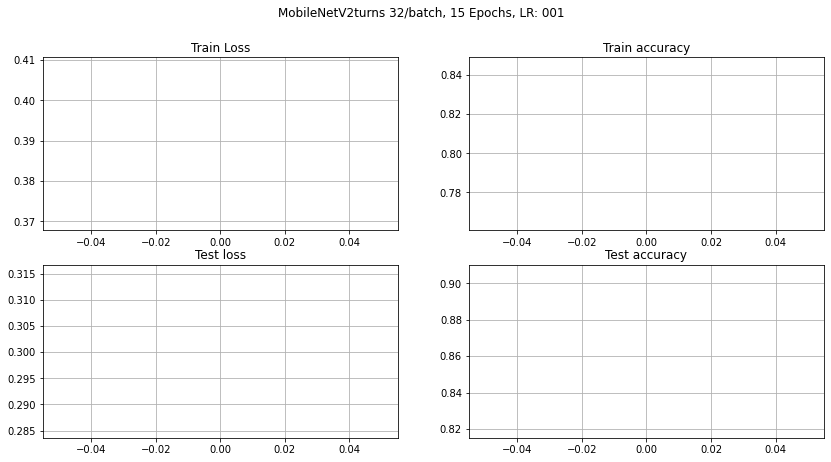

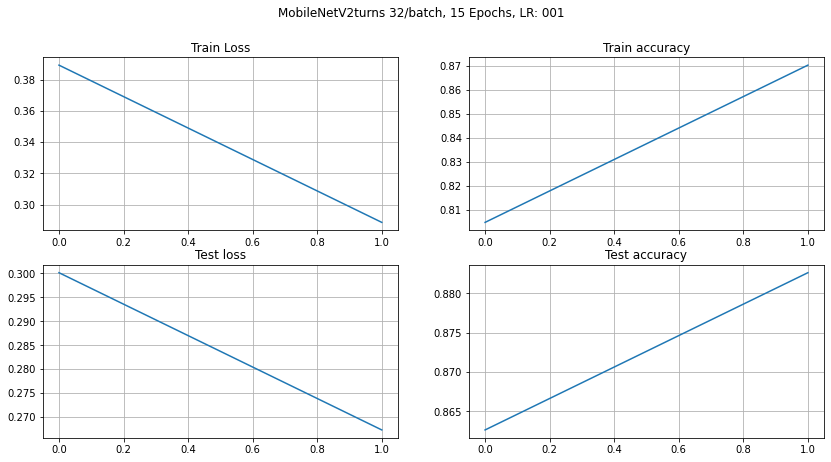

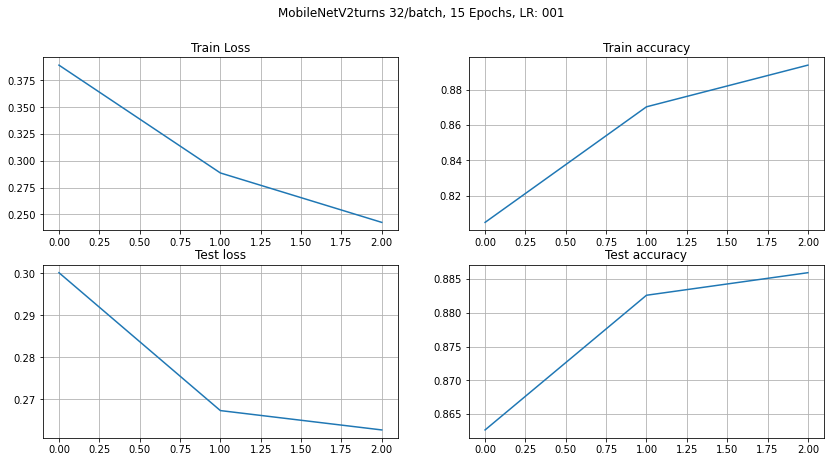

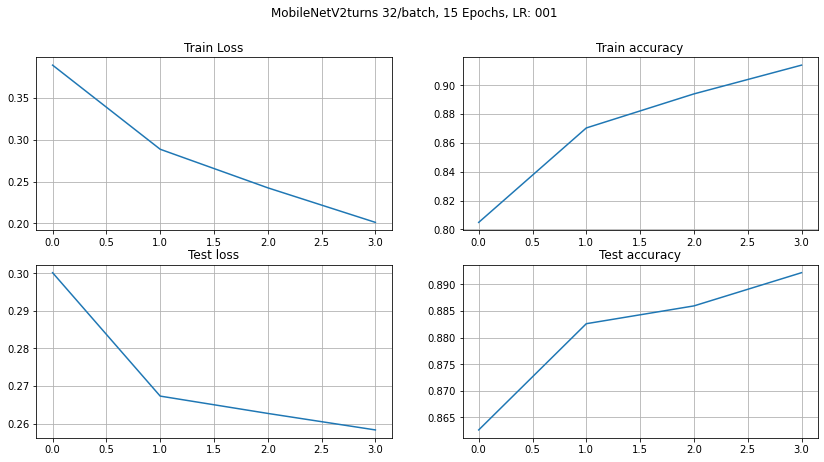

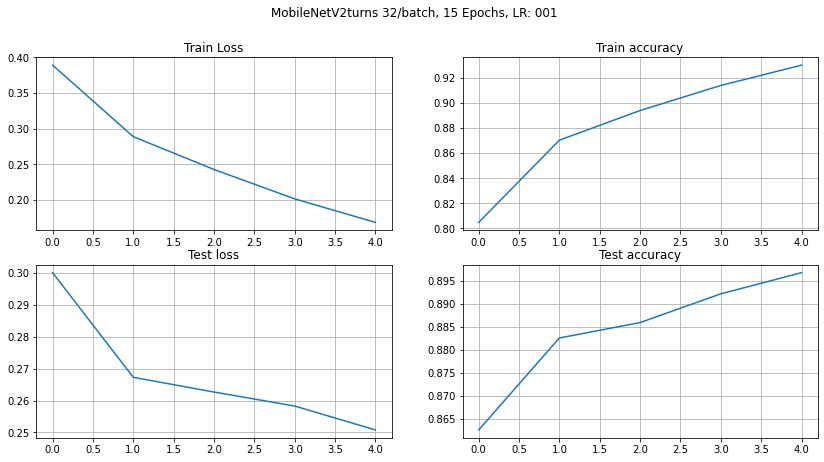

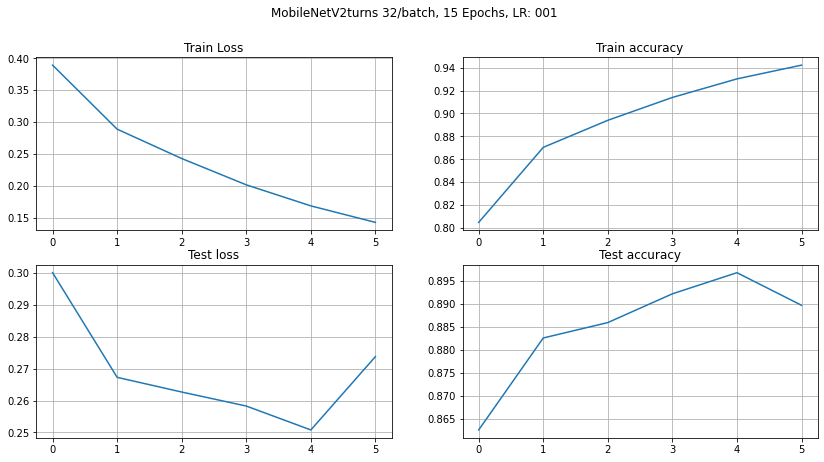

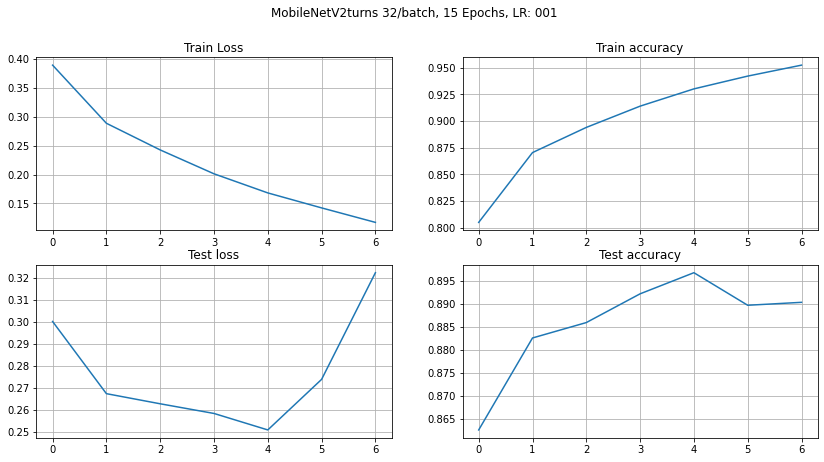

In [24]:
done = False

model = model.to(device)

print(f"{NAME} INITIALIZED")
send().msg(f"{NAME} INITIALIZED")

loss_func = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=LR, momentum=0.9)

train_loss_vals = []
train_accuracy_vals = []
test_loss_vals = []
test_accuracy_vals = []

start = time.time()
for ep in range(EPOCH):
  messages = ''

  print(f"Epoch: {ep+1}/{EPOCH}\nLR: {optimizer.param_groups[0]['lr']}")
  messages += f"\nEpoch: {ep+1}/{EPOCH}\nLR: {optimizer.param_groups[0]['lr']}" # for telegram

  vals = epoch(model, dataloader["TEST"], dataloader["TRAIN"], loss_func, optimizer, device)
  train_loss_vals.append(vals[0])
  train_accuracy_vals.append(vals[1])
  test_loss_vals.append(vals[2])
  test_accuracy_vals.append(vals[3])

  print(f"Test Loss: {test_loss_vals[-1]:.3f} Test Accuracy: {test_accuracy_vals[-1]:.3f}")
  print(f"Train Loss: {train_loss_vals[-1]:.3f} Train Accuracy: {train_accuracy_vals[-1]:.3f}")
  messages += f"\nTest Loss: {test_loss_vals[-1]:.3f} Test Accuracy: {test_accuracy_vals[-1]:.3f}" # for telegram
  messages += f"\nTrain Loss: {train_loss_vals[-1]:.3f} Train Accuracy: {train_accuracy_vals[-1]:.3f}"
  print(f"Time: {(time.time()-start)/60:.2f} min(s)")
  messages += f"\nTime elapsed: {(time.time()-start)/60:.2f} min(s)" # for telegram
  
  if len(test_loss_vals)>2:
    if all(x > test_loss_vals[-1] for x in test_loss_vals[:-1]):
      model_name = os.path.join(FOLDERS["MODELS"],f"{NAME}.pth")
      
      print(f"Improvement detected. Saving the model\n")
      messages += f"\nImprovement detected. Saving the model" # for telegram

      torch.save(model.state_dict(),model_name)
  fig, a = plt.subplots(2,2, squeeze=False, figsize=(14,7))
  a[0][0].plot(train_loss_vals)
  a[0][0].set_title("Train Loss")
  a[0][0].grid(True)
  a[0][1].plot(train_accuracy_vals)
  a[0][1].set_title("Train accuracy")
  a[0][1].grid(True)
  a[1][0].plot(test_loss_vals)
  a[1][0].set_title("Test loss")
  a[1][0].grid(True)
  a[1][1].plot(test_accuracy_vals)
  a[1][1].set_title("Test accuracy")
  a[1][1].grid(True)
  fig.suptitle(f"{NAME} {BATCH}/batch, {EPOCH} Epochs, LR: {str(optimizer.param_groups[0]['lr']).replace('0.','')}\n")
  # plt.show()
  if ep>2:
    performanceplot = f"PERFORMANCE.jpg"
    fig.savefig(performanceplot)
    send().pic(performanceplot)
  send().msg(messages)
  send().msg('———————————————————————')

print(f"Total time taken to train for {EPOCH} epochs on {NAME}: {(time.time()-start)/60:.2f} min(s)")
send().msg(f"Total time taken to train for {EPOCH} epochs {NAME}: {(time.time()-start)/60:.2f} min(s)")
print(f"{max(train_accuracy_vals)*100:.2f}% highest train accuracy at {train_accuracy_vals.index(max(train_accuracy_vals))} epoch and {max(test_accuracy_vals)*100:.2f}% highest test accuracy at {test_accuracy_vals.index(max(test_accuracy_vals))} epoch")
send().msg(f"{max(train_accuracy_vals)*100:.2f}% highest train accuracy at {train_accuracy_vals.index(max(train_accuracy_vals))} epoch and {max(test_accuracy_vals)*100:.2f}% highest test accuracy at {test_accuracy_vals.index(max(test_accuracy_vals))} epoch")
done = True

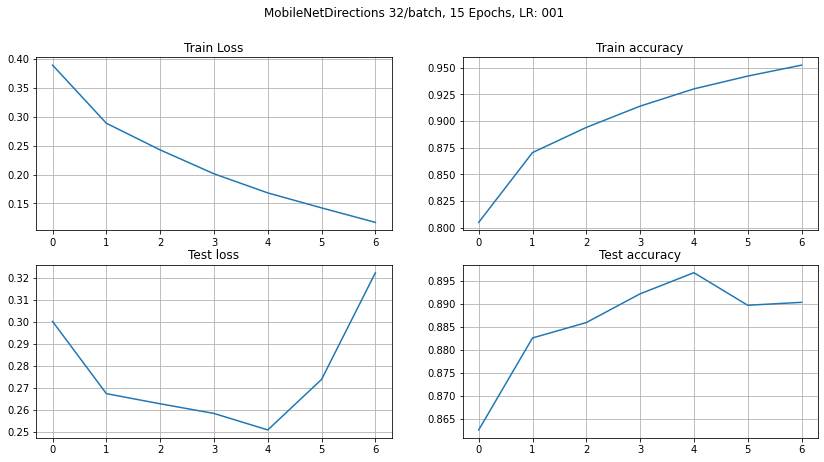

In [26]:
fig, a = plt.subplots(2,2, squeeze=False, figsize=(14,7))
a[0][0].plot(train_loss_vals)
a[0][0].set_title("Train Loss")
a[0][0].grid(True)
a[0][1].plot(train_accuracy_vals)
a[0][1].set_title("Train accuracy")
a[0][1].grid(True)
a[1][0].plot(test_loss_vals)
a[1][0].set_title("Test loss")
a[1][0].grid(True)
a[1][1].plot(test_accuracy_vals)
a[1][1].set_title("Test accuracy")
a[1][1].grid(True)
fig.suptitle(f"MobileNetDirections {BATCH}/batch, {EPOCH} Epochs, LR: {str(optimizer.param_groups[0]['lr']).replace('0.','')}\n")
plt.show()
performanceplot = f"{FOLDERS['PERFORMANCE']}/{NAME}.jpg"
fig.savefig(performanceplot)
send().pic(performanceplot)

In [ ]:
%reset